## Training
Prepapre dataset with the prepare_dataset notebook, before running this one.

In [1]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from time import time, sleep
import numpy as np
import os
import warnings; warnings.filterwarnings("ignore")
from utils import *

SAVE_DIR = f"data/{JOBID}"  
# DEV = torch.device('cpu') # for debugging, use cpu
os.makedirs(f"{SAVE_DIR}", exist_ok=True)
os.makedirs(f"{SAVE_DIR}/models", exist_ok=True)
print(f'DEV: {DEV}, has_screen: {LOCAL}, job id: {JOBID}')

# copy the python training to the directory (for cluster) (for local, it fails silently)
os.system(f"cp train.py {SAVE_DIR}/train.py")
os.system(f"cp utils.py {SAVE_DIR}/utils.py")

# SMALL, NORM, BIG = "small", "norm", "big"

DEV: cpu, has_screen: True, job id: local


cp: cannot stat 'train.py': No such file or directory


0

In [2]:

EPOCHS = 20 # number of epochs # 1000
# BATCH_SIZE = 128 # 128 
BATCH_SIZE = 64 # 64 <-

LOAD_PRETRAINED = None # Set it to None if you don't want to load pretrained model
# LOAD_PRETRAINED = "trained_models/pretrained_1809761.pth" # norm model

# LEARNING_RATE = 3e-4*np.logspace(0, -2, EPOCHS) 
# LEARNING_RATE = 3e-3*np.ones(EPOCHS) 
# LEARNING_RATE = 3e-3*np.logspace(0, -2, EPOCHS)  
LEARNING_RATE = 1e-3*np.logspace(0, -2, EPOCHS) # <-

# GSO_LOSS_RATIO = np.concatenate((np.linspace(1e-6, 3e-3, EPOCHS//2), np.linspace(3e-3, 0.0, EPOCHS//2))) 
MAX_GSO = 5e-3 # 3e-3 <-
GSO_LOSS_RATIO = np.concatenate((np.linspace(1e-6, MAX_GSO, EPOCHS//4), 
                                 np.linspace(MAX_GSO, MAX_GSO, EPOCHS//4), 
                                 np.linspace(MAX_GSO, 0.0, EPOCHS//4), 
                                 np.linspace(0.0, 0.0, EPOCHS//4))) # <-
# GSO_LOSS_RATIO = np.concatenate((MAX_GSO*np.logspace(-6, 0, EPOCHS//4), 
#                                  MAX_GSO*np.logspace(0, 0, EPOCHS//4), 
#                                  MAX_GSO*np.logspace(0, -10, EPOCHS//4), 
#                                  np.logspace(-12, -12, EPOCHS//4))) 
# GSO_LOSS_RATIO = np.zeros(EPOCHS) 

In [3]:
#checks
if LOAD_PRETRAINED is not None: assert os.path.exists(LOAD_PRETRAINED), "Pretrained model does not exist"
assert os.path.exists(TRAIN_DS_PATH), "Training dataset does not exist"
assert os.path.exists(EVAL_DS_PATH), "Evaluation dataset does not exist"
assert os.path.exists(SAVE_DIR), "Save directory does not exist"
assert len(LEARNING_RATE) == EPOCHS, "Learning rate array length does not match epochs"
assert len(GSO_LOSS_RATIO) == EPOCHS, "GSO loss ratio array length does not match epochs"

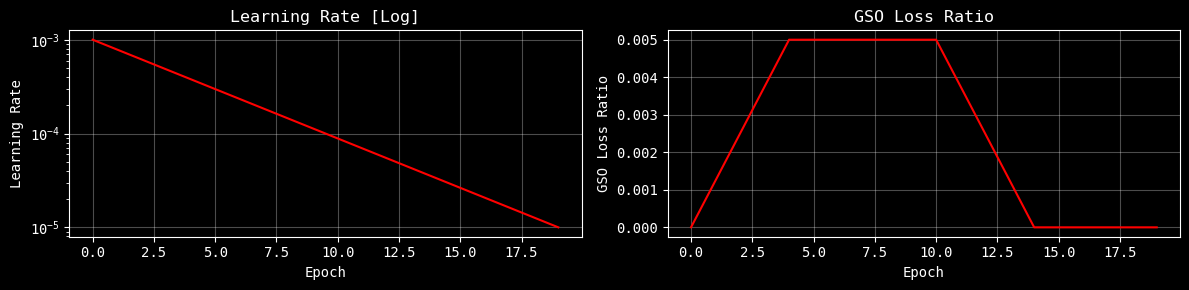

In [4]:
# plot schedulers: lr + gso loss ratio
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].set_title("Learning Rate [Log]")
ax[0].plot(LEARNING_RATE, color="red")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Learning Rate")
ax[0].set_yscale("log")
ax[1].set_title("GSO Loss Ratio")
ax[1].plot(GSO_LOSS_RATIO, color="red")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("GSO Loss Ratio")
plt.tight_layout()
plt.show() if LOCAL else plt.savefig(f"{SAVE_DIR}/schedulers.png")

In [ ]:
# create training and evaluation datasets
train_ds = LiuqeDataset(TRAIN_DS_PATH)
val_ds = LiuqeDataset(EVAL_DS_PATH)

Dataset: N:13600, memory:0.02GB
Dataset: N:3400, memory:0.00GB


## Training

In [ ]:
def train():
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
    model = LiuqeNet()  # instantiate model
    if LOAD_PRETRAINED is not None: # load pretrained model
        model.load_state_dict(torch.load(LOAD_PRETRAINED, map_location=torch.device("cpu"))) # load pretrained model
        print(f"Pretrained model loaded: {LOAD_PRETRAINED}")
    model.to(DEV) # move model to DEV
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE[0])
    loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss
    tlog_tot, tlog_mse, tlog_gso, elog_tot, elog_mse, elog_gso = [], [], [], [], [], [] # logs for losses
    start_time = time() # start time
    for ep in range(EPOCHS): # epochs
        epoch_time = time()
        for pg in optimizer.param_groups: pg['lr'] = LEARNING_RATE[ep] # update learning rate
        model.train()
        trainloss, evalloss = [], []
        for X, Y, r, z in train_dl:
            X, Y, r, z = X.to(DEV), Y.to(DEV), r.to(DEV), z.to(DEV) # move to DEV
            optimizer.zero_grad() # zero gradients
            yp = model(X, r, z) # forward pass
            assert yp.shape == Y.shape, f"Output shape {yp.shape} != {Y.shape}"
            gso, gsop = calc_gso_batch(Y, r, z, dev=DEV), calc_gso_batch(yp, r, z, dev=DEV) # calculate grad shafranov
            mse_loss = loss_fn(yp, Y) # mean squared error loss on Y
            gso_loss = loss_fn(gsop, gso) # PINN loss on grad shafranov
            loss = (1-GSO_LOSS_RATIO[ep])*mse_loss + GSO_LOSS_RATIO[ep]*gso_loss # total loss
            loss.backward() # backprop
            optimizer.step() # update weights 
            trainloss.append((loss.item(), mse_loss.item(), gso_loss.item())) # save batch losses
        model.eval() # evaluation mode
        with torch.no_grad():
            for X, Y, r, z in val_dl:
                X, Y, r, z = X.to(DEV), Y.to(DEV), r.to(DEV), z.to(DEV) # move to DEV
                yp = model(X, r, z)
                gso, gsop = calc_gso_batch(Y, r, z, dev=DEV), calc_gso_batch(yp, r, z, dev=DEV)
                mse_loss = loss_fn(yp, Y)
                gso_loss = loss_fn(gsop, gso)
                loss = (1-GSO_LOSS_RATIO[ep])*mse_loss + GSO_LOSS_RATIO[ep]*gso_loss # total loss
                evalloss.append((loss.item(), mse_loss.item(), gso_loss.item()))
        tloss_tot, tloss_mse, tloss_gso = map(lambda x: sum(x)/len(x), zip(*trainloss))
        eloss_tot, eloss_mse, eloss_gso = map(lambda x: sum(x)/len(x), zip(*evalloss))
        # save model if improved        
        endp = "\n" 
        if eloss_tot <= min(elog_tot, default=eloss_tot): 
            torch.save(model.state_dict(), f"{SAVE_DIR}/best_tot.pth"); endp=" [tot]\n"
        if eloss_mse <= min(elog_mse, default=eloss_mse):
            torch.save(model.state_dict(), f"{SAVE_DIR}/best_mse.pth"); endp=" [mse]\n"
        if eloss_gso <= min(elog_gso, default=eloss_gso):
            torch.save(model.state_dict(), f"{SAVE_DIR}/best_gso.pth"); endp=" [gso]\n"
        tlog_tot.append(tloss_tot); tlog_mse.append(tloss_mse); tlog_gso.append(tloss_gso)
        elog_tot.append(eloss_tot); elog_mse.append(eloss_mse); elog_gso.append(eloss_gso) 
        print(f"[{ep+1}/{EPOCHS}] "
            f"Eval -> tot {eloss_tot:.1e}, mse {eloss_mse:.1e}, gso {eloss_gso:.1e}, " + 
            f"lr {LEARNING_RATE[ep]:.1e}, r {GSO_LOSS_RATIO[ep]:.1e}, {time()-epoch_time:.0f}s, eta {(time()-start_time)*(EPOCHS-ep)/(ep+1)/60:.0f}m", end=endp)
        if ep >= 10 and ((eloss_gso > 30.0 and GSO_LOSS_RATIO[ep] > 0.01) or eloss_mse > .2): return False, () # stop training, if not converging, try again
    print(f"Training time: {(time()-start_time)/60:.0f}mins")
    print(f"Best losses: tot {min(elog_tot):.3e}, mse {min(elog_mse):.3e}, gso {min(elog_gso):.4f}")
    print(f"Estimated MAE: tot {np.sqrt(min(elog_tot)):.3e}, mae {np.sqrt(min(elog_mse)):.3e}, gso {np.sqrt(min(elog_gso)):.4f}")
    for l, n in zip([tlog_tot, tlog_mse, tlog_gso], ["tot", "mse", "gso"]): np.save(f"{SAVE_DIR}/train_{n}_losses.npy", l) # save losses
    for l, n in zip([elog_tot, elog_mse, elog_gso], ["tot", "mse", "gso"]): np.save(f"{SAVE_DIR}/eval_{n}_losses.npy", l) # save losses
    return True, (tlog_tot, tlog_mse, tlog_gso, elog_tot, elog_mse, elog_gso)

# train the model (multiple attempts)
for i in range(20): 
    print('Starting training...')
    success, logs = train()
    if success: tlog_tot, tlog_mse, tlog_gso, elog_tot, elog_mse, elog_gso = logs; break
    else: print(f"Convergence failed, retrying... {i+1}/20")
# if not success: delete the files and exit:
if not success: os.system(f"rm -rf {SAVE_DIR}")
assert success, "Training failed, no model saved"

Starting training...
[1/20] Eval -> tot 6.5e-03, mse 6.5e-03, gso 3.7e+01, lr 1.0e-03, r 1.0e-06, 1s, eta 0m [gso]
[2/20] Eval -> tot 4.1e-02, mse 6.5e-03, gso 2.7e+01, lr 7.8e-04, r 1.3e-03, 1s, eta 0m [gso]
[3/20] Eval -> tot 7.3e-02, mse 6.5e-03, gso 2.7e+01, lr 6.2e-04, r 2.5e-03, 1s, eta 0m [gso]
[4/20] Eval -> tot 9.7e-02, mse 6.5e-03, gso 2.4e+01, lr 4.8e-04, r 3.8e-03, 1s, eta 0m [gso]
[5/20] Eval -> tot 1.1e-01, mse 6.4e-03, gso 2.1e+01, lr 3.8e-04, r 5.0e-03, 1s, eta 0m [gso]
[6/20] Eval -> tot 9.6e-02, mse 6.3e-03, gso 1.8e+01, lr 3.0e-04, r 5.0e-03, 1s, eta 0m [gso]
[7/20] Eval -> tot 8.7e-02, mse 6.2e-03, gso 1.6e+01, lr 2.3e-04, r 5.0e-03, 1s, eta 0m [gso]
[8/20] Eval -> tot 8.2e-02, mse 6.2e-03, gso 1.5e+01, lr 1.8e-04, r 5.0e-03, 1s, eta 0m [gso]
[9/20] Eval -> tot 8.0e-02, mse 6.2e-03, gso 1.5e+01, lr 1.4e-04, r 5.0e-03, 1s, eta 0m [gso]
[10/20] Eval -> tot 7.8e-02, mse 6.2e-03, gso 1.4e+01, lr 1.1e-04, r 5.0e-03, 1s, eta 0m [gso]
[11/20] Eval -> tot 7.7e-02, mse 6.2e-

Plotting losses...


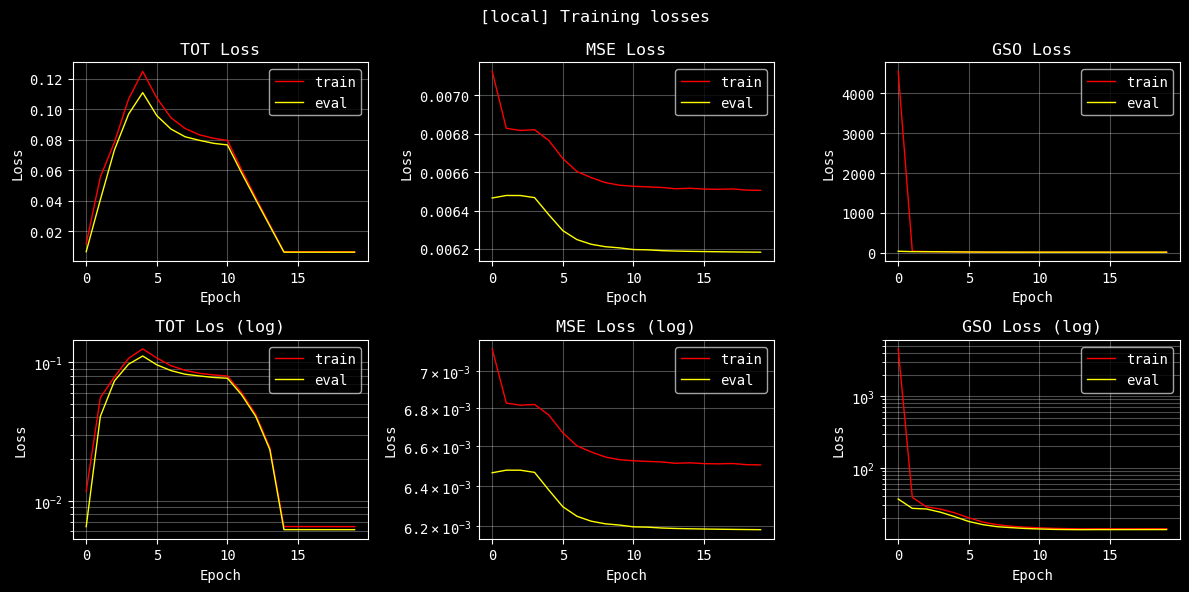

In [7]:
# plot losses
print("Plotting losses...")
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ce, ct = "yellow", "red"
lw = 1.0
ax[0,0].set_title("TOT Loss")
ax[0,0].plot(tlog_tot, color=ct, label="train", linewidth=lw)
ax[0,0].plot(elog_tot, color=ce, label="eval", linewidth=lw)
ax[0,1].set_title("MSE Loss")
ax[0,1].plot(tlog_mse, color=ct, label="train", linewidth=lw)
ax[0,1].plot(elog_mse, color=ce, label="eval", linewidth=lw)
ax[0,2].set_title("GSO Loss")
ax[0,2].plot(tlog_gso, color=ct, label="train", linewidth=lw)
ax[0,2].plot(elog_gso, color=ce, label="eval", linewidth=lw)
#now the same but with log scale
ax[1,0].set_title("TOT Los (log)")
ax[1,0].plot(tlog_tot, color=ct, label="train", linewidth=lw)
ax[1,0].plot(elog_tot, color=ce, label="eval", linewidth=lw)
ax[1,0].set_yscale("log")
ax[1,0].grid(True, which="both", axis="y")

ax[1,1].set_title("MSE Loss (log)")
ax[1,1].plot(tlog_mse, color=ct, label="train", linewidth=lw)
ax[1,1].plot(elog_mse, color=ce, label="eval", linewidth=lw)
ax[1,1].set_yscale("log")
ax[1,1].grid(True, which="both", axis="y")

ax[1,2].set_title("GSO Loss (log)")
ax[1,2].plot(tlog_gso, color=ct, label="train", linewidth=lw)
ax[1,2].plot(elog_gso, color=ce, label="eval", linewidth=lw)
ax[1,2].set_yscale("log")
ax[1,2].grid(True, which="both", axis="y")
plt.suptitle(f"[{JOBID}] Training losses")
for a in ax.flatten(): a.legend(); a.set_xlabel("Epoch"); a.set_ylabel("Loss")
plt.tight_layout()
plt.show() if LOCAL else plt.savefig(f"{SAVE_DIR}/losses.png")

Testing network output...


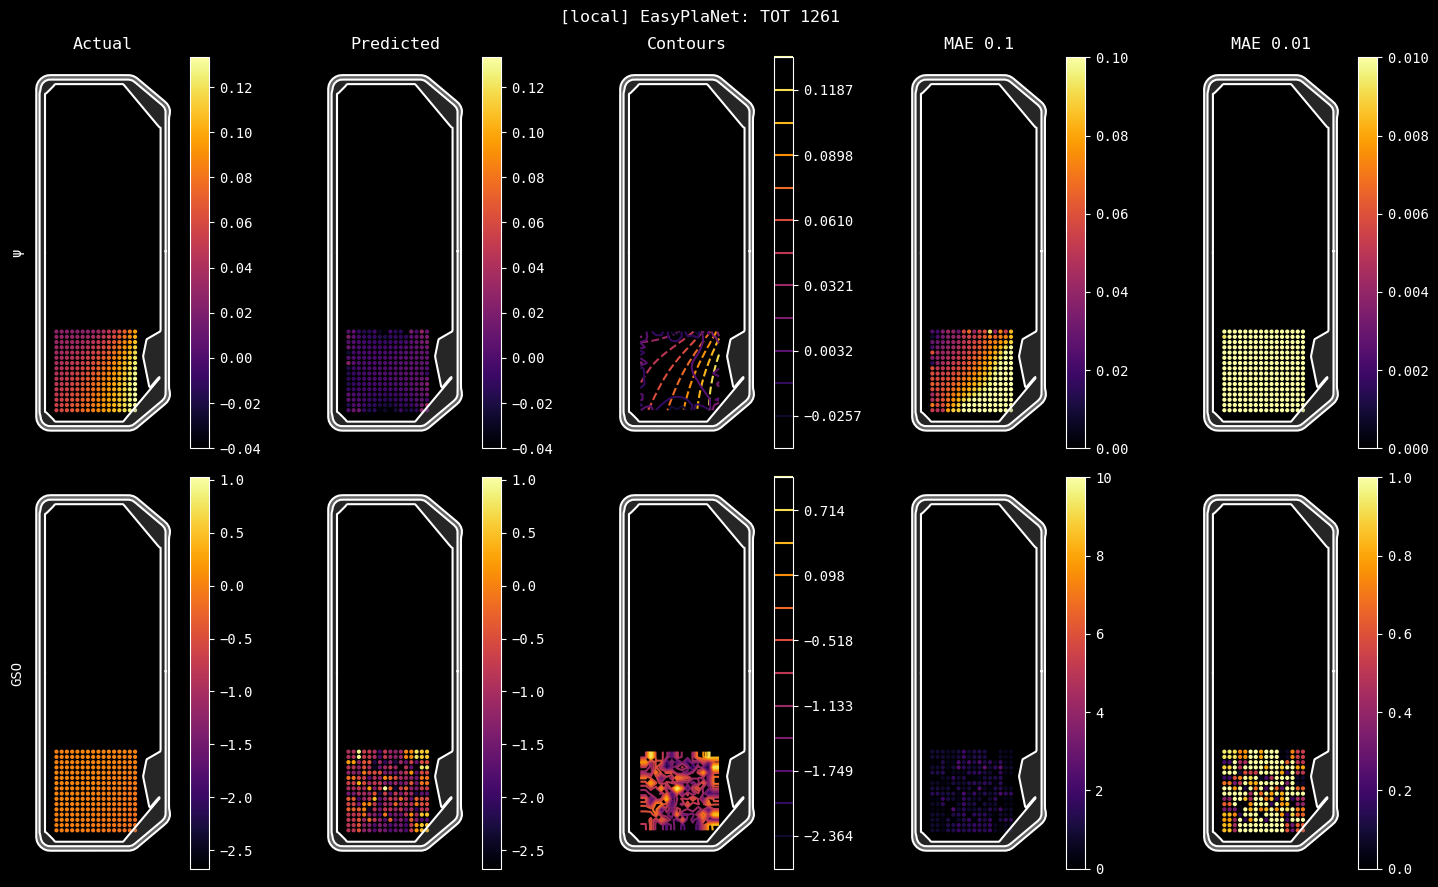

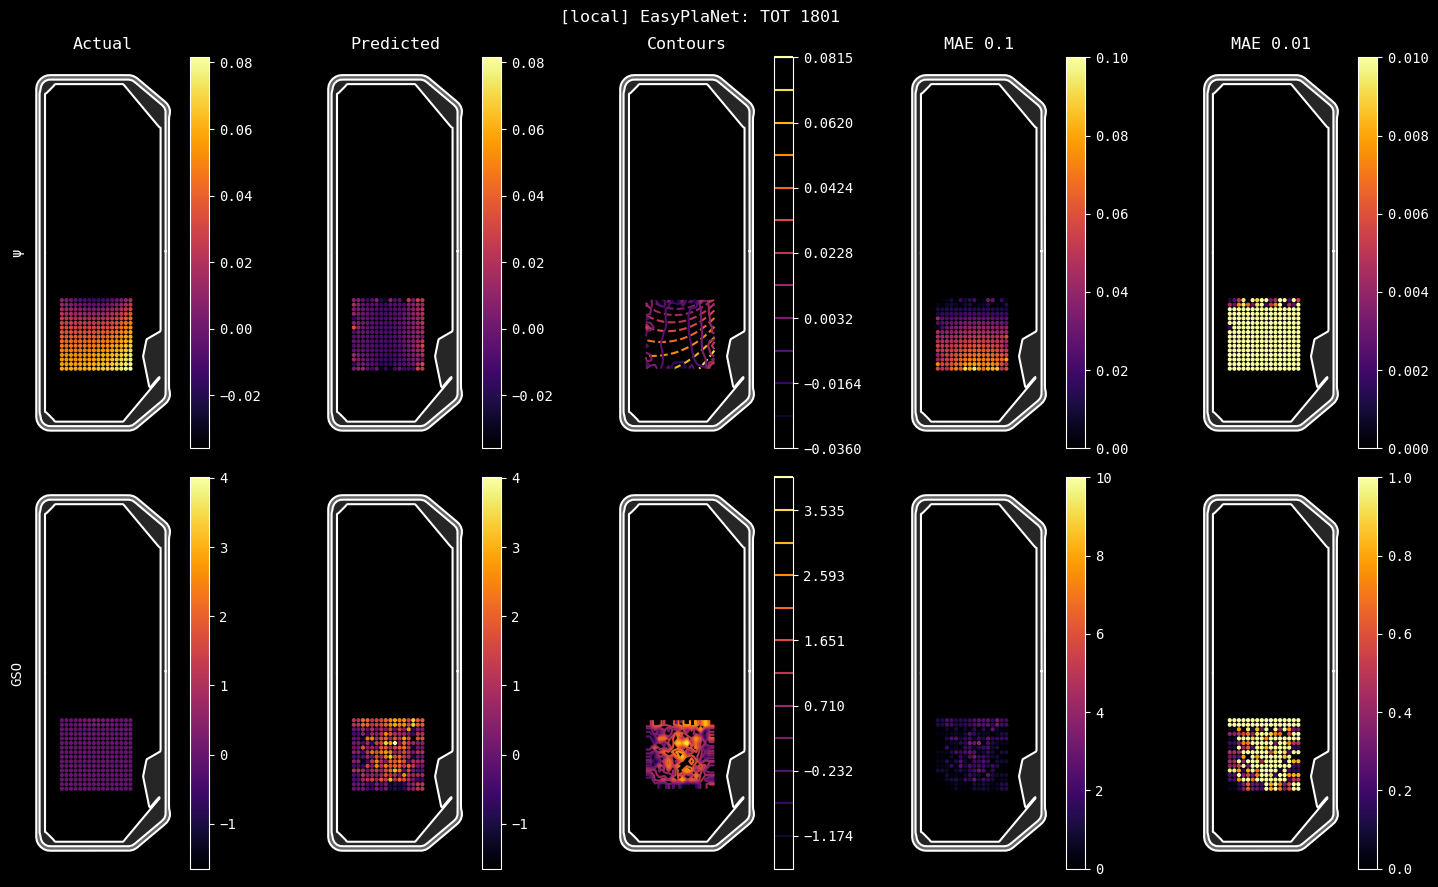

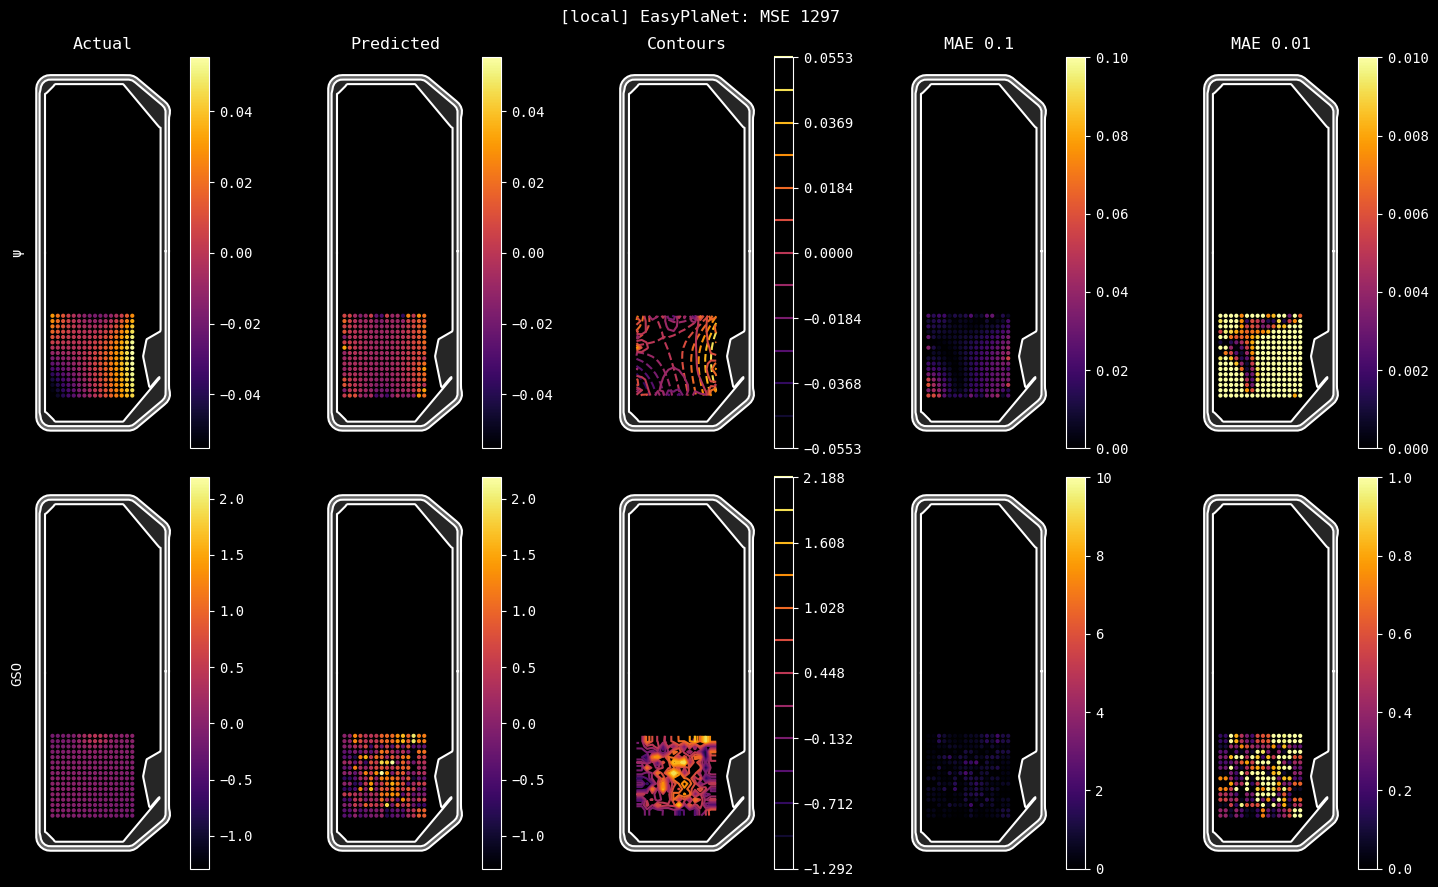

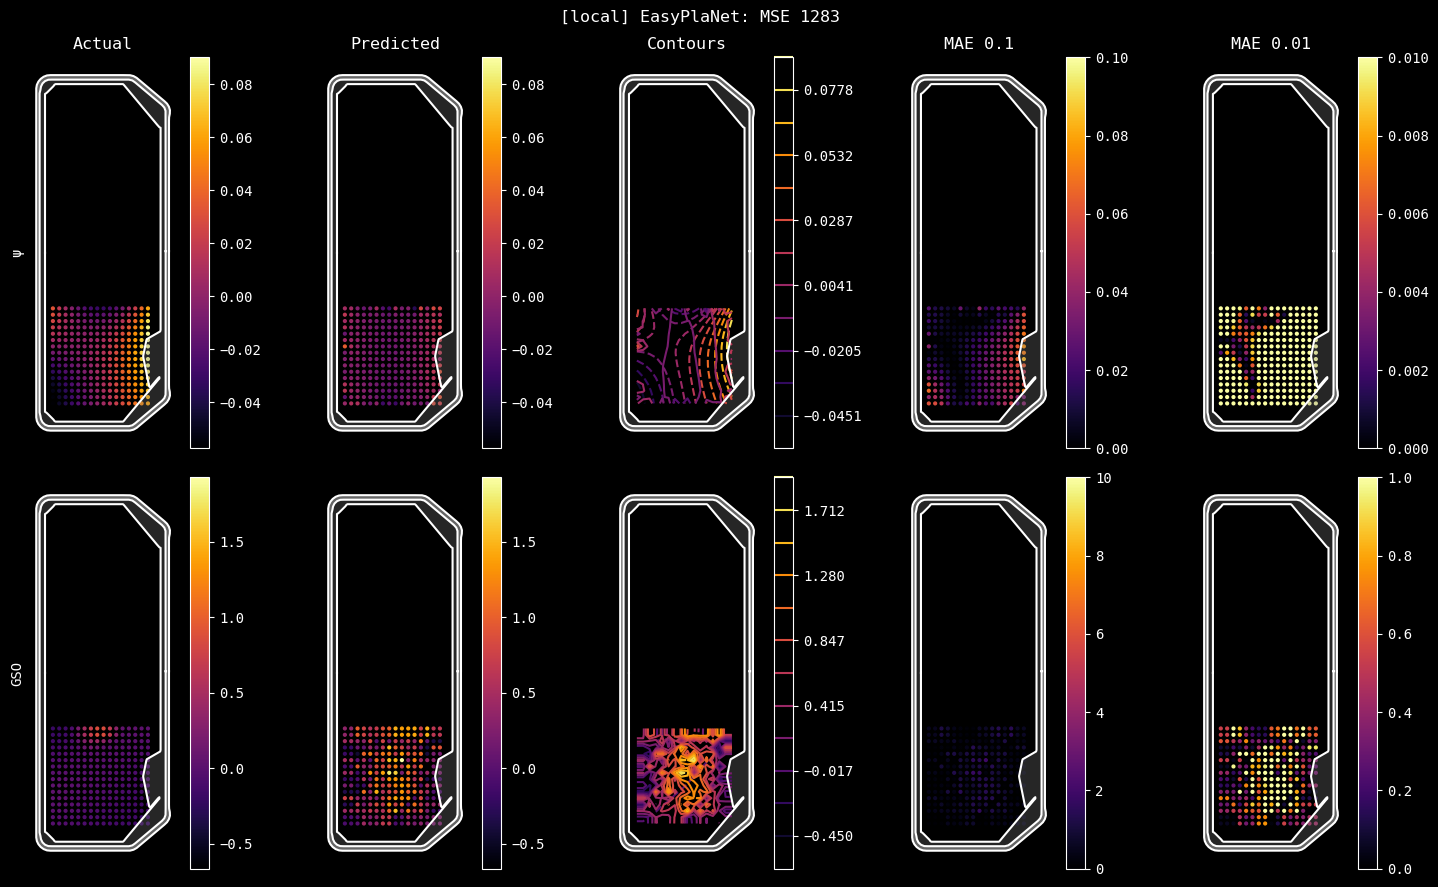

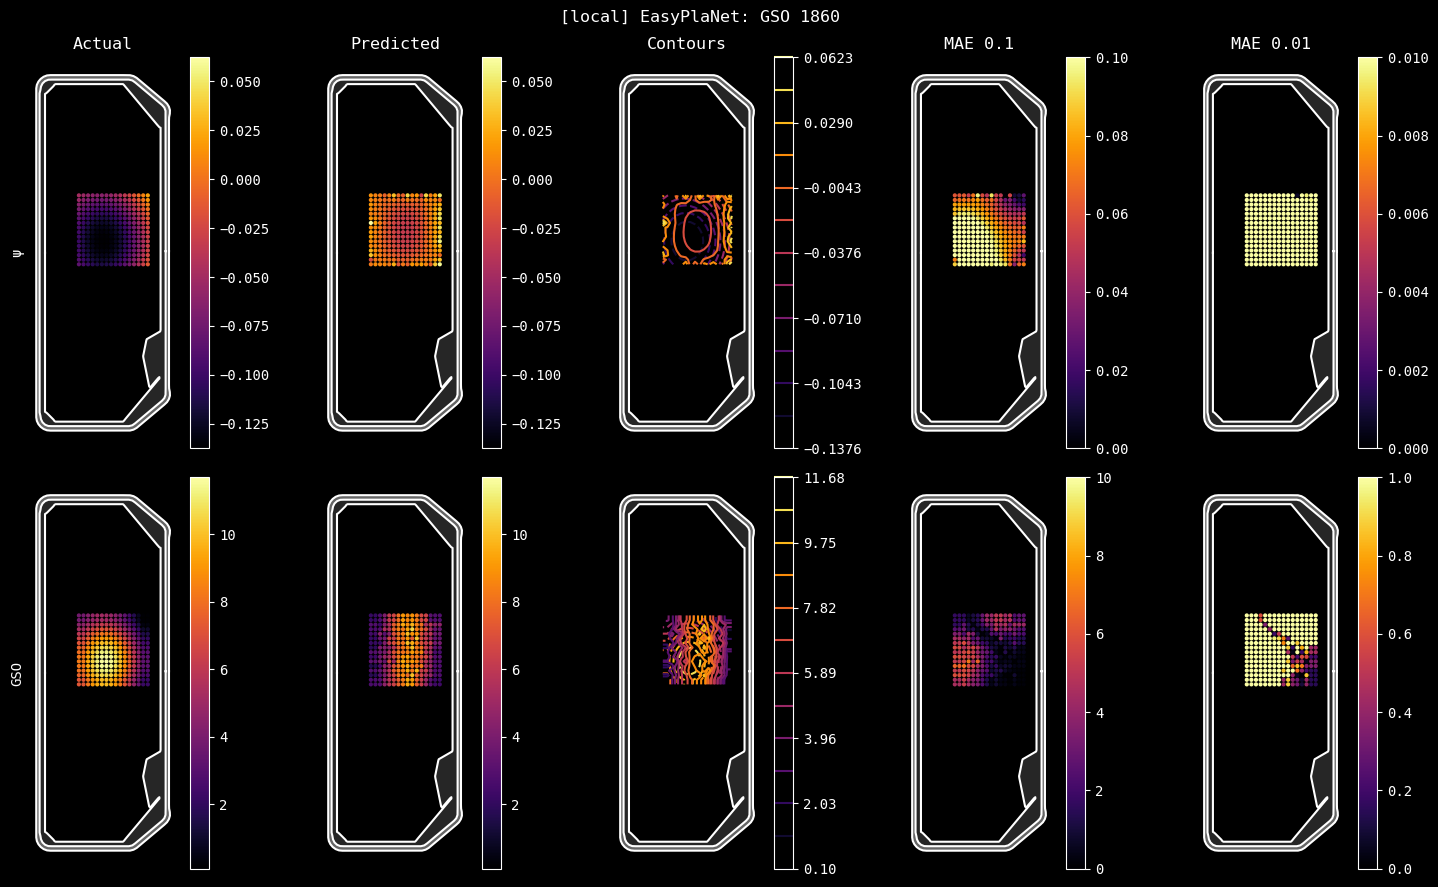

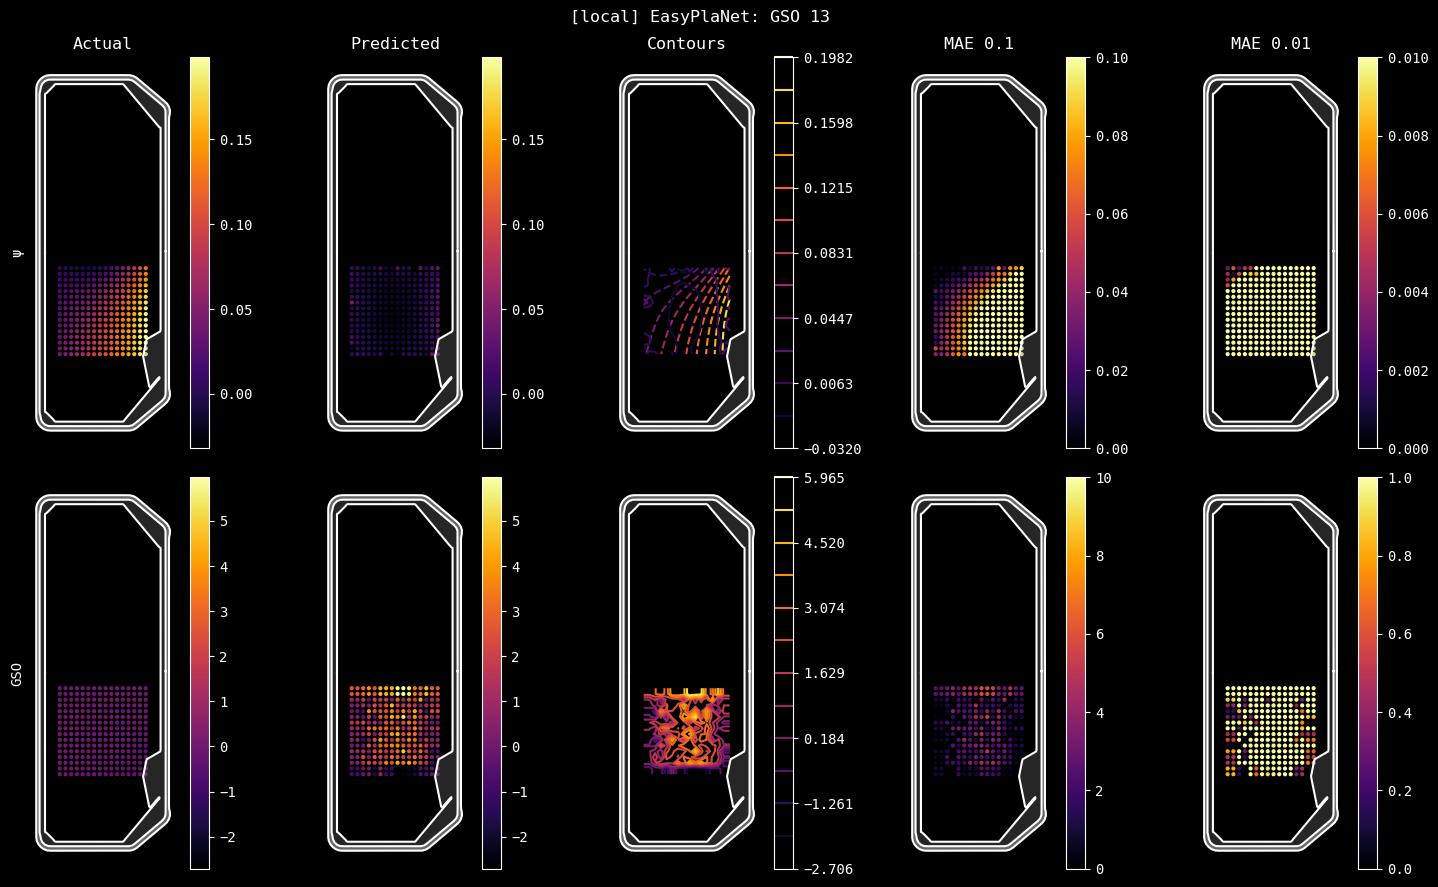

In [ ]:
# testing network output
print("Testing network output...")
for mn, titl in zip(["best_tot.pth", "best_mse.pth", "best_gso.pth"], ["TOT", "MSE", "GSO"]):
    model = LiuqeNet() # instantiate model
    model.load_state_dict(torch.load(f'{SAVE_DIR}/{mn}', map_location=torch.device("cpu"))) # load pretrained model
    plot_network_outputs(SAVE_DIR, val_ds, model, titl)

In [ ]:
# test inference speed
print("Testing inference speed...")
model = LiuqeNet()
model.load_state_dict(torch.load(f"{SAVE_DIR}/best_tot.pth"))
model.eval()
ds = val_ds
n_samples = 100
random_idxs = np.random.choice(n_samples, len(ds))
#cpu
cpu_times1, cpu_times2 = [], []
for i in random_idxs:
    start_t = time()
    x, y, r, z = ds[i]
    x, y, r, z = x.to('cpu'), y.to('cpu'), r.to('cpu'), z.to('cpu')
    x, y, r, z = x.view(1,-1), y.view(1,1,NGZ,NGR), r.view(1,NGZ), z.view(1,NGR)
    start_t2 = time()
    yp = model(x, r, z)
    end_t = time()
    cpu_times1.append(end_t - start_t); cpu_times2.append(end_t - start_t2) 
# DEV
model.to(DEV)
dev_times1, dev_times2 = [], []
for i in random_idxs:
    x, y, r, z = ds[i]
    x, y, r, z = x.to(DEV), y.to(DEV), r.to(DEV), z.to(DEV)
    x, y, r, z = x.view(1,-1), y.view(1,1,NGZ,NGR), r.view(1,NGR), z.view(1,NGZ)
    start_t = time()
    start_t2 = time()
    yp = model(x, r, z)
    end_t = time()
    dev_times1.append(end_t - start_t); dev_times2.append(end_t - start_t2)    
cpu_times1, dev_times1 = np.array(cpu_times1)*1000, np.array(dev_times1)*1000
cpu_times2, dev_times2 = np.array(cpu_times2)*1000, np.array(dev_times2)*1000
print(f"cpu: inference time: [full -> {cpu_times1.mean():.5f}ms, std: {cpu_times1.std():.5f}]")
print(f"cpu: inference time: [inference only -> {cpu_times2.mean():.5f}ms, std: {cpu_times2.std():.5f}]")
print(f"dev: inference time: [full -> {dev_times1.mean():.5f}ms, std: {dev_times1.std():.5f}]")
print(f"dev: inference time: [inference only -> {dev_times2.mean():.5f}ms, std: {dev_times2.std():.5f}]")

Testing inference speed...
cpu: inference time: [full -> 0.14521ms, std: 0.01619]
cpu: inference time: [inference only -> 0.13600ms, std: 0.01512]
dev: inference time: [full -> 0.13642ms, std: 0.01114]
dev: inference time: [inference only -> 0.13635ms, std: 0.01113]


In [10]:
print(f"{JOBID} done")
if not LOCAL: sleep(30) # wait for files to update (for cluster)

local done


In [11]:
#copy the log file to the folder
os.system(f"cp jobs/{JOBID}.txt {SAVE_DIR}/log.txt")

cp: cannot stat 'jobs/local.txt': No such file or directory


256